# **Limpieza de datos operativos**

Partiendo de los vuelos de salida se hace un análisis de las dimensiones de calidad de datos, se añaden datos nuevos de región y se genera un nuevo dataset limpio de vuelos.

## Librerias

In [104]:
%load_ext autoreload
%autoreload 2

from typing import Dict, List, Any
import gc
import re

from unidecode import unidecode
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

import univariate_utils, multivariate_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constantes

In [105]:
# Flight file
FLIGHT_FILE = "raw_data/Seguimiento PAX.xlsx"
# Departures sheet
DEPARTURE_SHEET = "Salidas"

In [106]:
# Name of relevant flight columns
RELEVANT_FLIGHT_COLUMNS = [
    # Categorical
    "IATA CODE",
    "Destino",
    "Tipo de vuelo",
    "Sala",
    "Muelle",
    "FECHA DIA",
    "AEROLÍNEA",
    "Tipo aerolínea",
    # Date
    "STD",
    # Numerical
    "Pasajeros saliendo",
    "Hora entera",
    "Semana",
    "Mes",
    "Día",
    "Año"
]

In [107]:
FLIGHTS_SAVE_FILE = "data/clean_flights.parquet"

## Utils

In [108]:
def load_flight_data() -> pd.DataFrame:
    """Reads flights departures"""
    return pd.read_excel(
        FLIGHT_FILE,
        sheet_name=DEPARTURE_SHEET
    )

In [109]:
def safe_standardize_text(text: str) -> str:
    """Standardizes text to lower and deaccented form"""
    try:
        try:
            is_nan = np.isnan(text)
        except:
            is_nan = text is None
        if is_nan:
            return np.nan
        else:
            return re.sub(
                r"\s+",
                " ",
                re.sub(
                    r'\W+',
                    " ",
                    unidecode(str(text)).lower().strip()
                )
            ).strip()
    except:
        return np.nan

In [110]:
def safe_standardize_int(value: Any) -> int:
    """Safely converts value to int"""
    try:
        return np.int64(value)
    except:
        return np.nan

In [111]:
def standardize_categories(df: pd.DataFrame, col: str, fixing_map: Dict[Any, Any]) -> None:
    """Standardizes dataframe column categories based on a fix map"""
    df[col] = df[col].apply(
        lambda value: fixing_map[value]
        if value in fixing_map.keys()
        else value
    )

In [112]:
def safe_standardize_date(date_val: Any) -> pd.Series:
    """Converts a column into a date column"""
    try:
        return date_val.date()
    except:
        return pd.to_datetime(date_val).date()

In [113]:
def standardize_flights(df: pd.DataFrame) -> pd.DataFrame:
    """Selects relevant columns and transform categories into standard values"""
    df_flight_data = df_flights[RELEVANT_FLIGHT_COLUMNS].copy(deep=True)
    
    df_flight_data["Destino"] = df_flight_data["Destino"].apply(
        safe_standardize_text
    )
    df_flight_data["Tipo de vuelo"] = df_flight_data["Tipo de vuelo"].apply(
        safe_standardize_text
    )
    df_flight_data["Sala"] = df_flight_data["Sala"].apply(
        safe_standardize_text
    )
    df_flight_data["Muelle"] = df_flight_data["Muelle"].apply(
        safe_standardize_text
    )
    df_flight_data["FECHA DIA"] = df_flight_data["FECHA DIA"].apply(
        safe_standardize_text
    )
    df_flight_data["AEROLÍNEA"] = df_flight_data["AEROLÍNEA"].apply(
        safe_standardize_text
    )
    df_flight_data["Tipo aerolínea"] = df_flight_data["Tipo aerolínea"].apply(
        safe_standardize_text
    )
    df_flight_data["Pasajeros saliendo"] = df_flight_data["Pasajeros saliendo"].apply(
        safe_standardize_int
    )
    df_flight_data["Hora entera"] = df_flight_data["Hora entera"].apply(
        safe_standardize_int
    )  
    df_flight_data["Semana"] = df_flight_data["Semana"].apply(
        safe_standardize_int
    )
    df_flight_data["Mes"] = df_flight_data["Mes"].apply(
        safe_standardize_int
    )
    df_flight_data["Día"] = df_flight_data["Día"].apply(
        safe_standardize_int
    )
    df_flight_data["Año"] = df_flight_data["Año"].apply(
        safe_standardize_int
    )
    df_flight_data["STD_date"] = df_flight_data["STD"].apply(safe_standardize_date)

    return df_flight_data

In [114]:
def clip_data_by_iqr(df, col, strategy, iqr_multiplier):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    bottom_limit = Q1 - iqr_multiplier * IQR
    top_limit = Q3 + iqr_multiplier * IQR
    
    is_low = df[col] <= bottom_limit
    is_high = df[col] >= top_limit
    
    if strategy == "bottom":
        df.loc[is_low, col] = bottom_limit
    if strategy == "top":
        df.loc[is_high, col] = top_limit
    else:
        df.loc[is_low, col] = bottom_limit
        df.loc[is_high, col] = top_limit

## Ejecucion

### Carga de vuelos
Se leen los vuelos de salida.

In [115]:
df_flights = load_flight_data()

### Seleccion de columnas relevantes de vuelos (Dimension de relevancia)

Acorde a lo revisado con negocio y en el equipo se toma solo una serie de columnas relevantes para el analisis y la regresion. Este dataframe contiene un numero de nulos extremadamente bajo, pudiendose eliminar las filas con esta condicion (dimension de completitud a nivel de atributo).

In [116]:
df_flights.columns

Index(['Aerolinea', 'Vuelo de salida', 'IATA CODE', 'Destino',
       'Pasajeros saliendo', 'STD', 'Posicion de salida', 'Tipo V',
       'Tipo de vuelo', 'Sala', 'Sala Antigua', 'Tipo de aeronave', 'ETD',
       'ATD', 'Ofchocks', 'Max pasajeros', 'Calificador de salida',
       'Matricula', 'Fecha de salida', 'Muelle', 'Hora', 'Hora entera', 'OPER',
       'FECHA DIA', 'AEROLÍNEA', 'Hora compra', 'Tipo aerolínea', 'Semana',
       'Mes', 'Día', 'Año'],
      dtype='object')

In [117]:
df_flights[RELEVANT_FLIGHT_COLUMNS].head(5)

,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,FECHA DIA,AEROLÍNEA,Tipo aerolínea,STD,Pasajeros saliendo,Hora entera,Semana,Mes,Día,Año
0,CTG,Cartagena,Doméstico,D11,D Nacional sur,martes,AVIANCA S.A,Legacy,2020-09-01 08:05:00,133,8,36,9,1,2020
1,CUC,Cúcuta,Doméstico,D4,D Nacional sur,martes,AVIANCA S.A,Legacy,2020-09-01 09:00:00,88,9,36,9,1,2020
2,PEI,Pereira,Doméstico,D15A,D Nacional sur,martes,EASYFLY S.A.S.,Regional,2020-09-01 07:05:00,20,7,36,9,1,2020
3,CTG,Cartagena,Doméstico,D15B,D Nacional sur,martes,VIVA COLOMBIA S.A.,Low Cost,2020-09-01 09:25:00,131,9,36,9,1,2020
4,BAQ,Barranquilla,Doméstico,D1,D Nacional sur,martes,AVIANCA S.A,Legacy,2020-09-01 06:11:00,127,6,36,9,1,2020


In [118]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344146 entries, 0 to 344145
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Aerolinea              344146 non-null  object        
 1   Vuelo de salida        344146 non-null  object        
 2   IATA CODE              344146 non-null  object        
 3   Destino                344146 non-null  object        
 4   Pasajeros saliendo     344146 non-null  int64         
 5   STD                    344146 non-null  object        
 6   Posicion de salida     344072 non-null  object        
 7   Tipo V                 344146 non-null  object        
 8   Tipo de vuelo          344146 non-null  object        
 9   Sala                   344146 non-null  object        
 10  Sala Antigua           344146 non-null  object        
 11  Tipo de aeronave       344146 non-null  object        
 12  ETD                    344040 non-null  obje

In [119]:
df_flights[RELEVANT_FLIGHT_COLUMNS].isnull().sum()/len(df_flights)

IATA CODE             0.000000
Destino               0.000000
Tipo de vuelo         0.000000
Sala                  0.000000
Muelle                0.000000
FECHA DIA             0.000000
AEROLÍNEA             0.000003
Tipo aerolínea        0.000003
STD                   0.000000
Pasajeros saliendo    0.000000
Hora entera           0.000000
Semana                0.000000
Mes                   0.000000
Día                   0.000000
Año                   0.000000
dtype: float64

### Estandarizacion de datos de vuelo

Se aplica un proceso similar al de ventas, en donde se normaliza el texto y se asegura el tipo de valor en las variables numericas.

In [120]:
df_clean_flights = standardize_flights(df_flights)

In [121]:
df_clean_flights.isnull().sum()/len(df_flights)

IATA CODE             0.000000
Destino               0.000000
Tipo de vuelo         0.000000
Sala                  0.000000
Muelle                0.000000
FECHA DIA             0.000000
AEROLÍNEA             0.000003
Tipo aerolínea        0.000003
STD                   0.000000
Pasajeros saliendo    0.000000
Hora entera           0.000000
Semana                0.000000
Mes                   0.000000
Día                   0.000000
Año                   0.000000
STD_date              0.000000
dtype: float64

#### Eliminacion de filas nulas en AEROLÍNEA y Tipo aerolínea (Dimension de completitud a nivel de atributo)
Como estas columnas tienen un numero de nulos menor al 1%, pero son necesarias para la regresion, se eliminan las pocas filas con esta condicion.

In [122]:
df_clean_flights.dropna(
    subset=["Tipo aerolínea", "AEROLÍNEA"],
    inplace=True
)

#### Aseguramiento de tipos de dato entero
Dependiendo de la version de pandas, el metodo de estandarizacion de datos enteros puede entender la columna como float64, y es necesario hacer la correccion.

In [123]:
for col in ["Pasajeros saliendo", "Hora entera", "Semana", "Mes", "Día", "Año"]:
    df_clean_flights[col] = df_clean_flights[col].astype(int)

### Dimensiones de calidad de variables numericas

Se evaluan posibles anomalias y se establecen correciones:
- En la dimension de conformidad se tienen vuelos con pasajeros saliendo mas extremos de lo "normal", por encima de 193, asi que se hace clipping. Tambien hay vuelos de 0 pasajeros, pero esto requiere investigar con negocio.
- Las demas variables numericas presentan rangos de valores aceptables.

In [124]:
univariate_utils.make_not_graphic_analysis(df_clean_flights)

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
Index: 344145 entries, 0 to 344145
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   IATA CODE           344145 non-null  object
 1   Destino             344145 non-null  object
 2   Tipo de vuelo       344145 non-null  object
 3   Sala                344145 non-null  object
 4   Muelle              344145 non-null  object
 5   FECHA DIA           344145 non-null  object
 6   AEROLÍNEA           344145 non-null  object
 7   Tipo aerolínea      344145 non-null  object
 8   STD                 344145 non-null  object
 9   Pasajeros saliendo  344145 non-null  int32 
 10  Hora entera         344145 non-null  int32 
 11  Semana              344145 non-null  int32 
 12  Mes                 344145 non-null  int32 
 13  Día                 344145 non-null  int32 
 14  Año                 344145 non-null  int32 
 15  STD_date            344145 non-

IATA CODE             0.0
Destino               0.0
Tipo de vuelo         0.0
Sala                  0.0
Muelle                0.0
FECHA DIA             0.0
AEROLÍNEA             0.0
Tipo aerolínea        0.0
STD                   0.0
Pasajeros saliendo    0.0
Hora entera           0.0
Semana                0.0
Mes                   0.0
Día                   0.0
Año                   0.0
STD_date              0.0
dtype: float64

----- Object column statistics -----


,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,FECHA DIA,AEROLÍNEA,Tipo aerolínea,STD,STD_date
count,344145,344145,344145,344145,344145,344145,344145,344145,344145,344145
unique,126,122,2,75,5,7,52,5,244741,1099
top,MDE,medellin,domestico,d3,d nacional sur,viernes,avianca s a,legacy,2021-07-20 13:30:00,2023-01-02
freq,36940,42361,254283,10244,158427,50841,167018,256334,12,426


----- Number column statistics -----


,Pasajeros saliendo,Hora entera,Semana,Mes,Día,Año
count,344145.000000,344145.000000,344145.000000,344145.000000,344145.000000,344145.000000
mean,126.469395,12.568211,26.080237,6.413038,15.710012,2021.905862
std,52.932171,5.513929,14.916871,3.411267,8.818160,0.855722
min,0.000000,0.000000,1.000000,1.000000,1.000000,2020.000000
5%,37.000000,5.000000,3.000000,1.000000,2.000000,2021.000000
25%,94.000000,8.000000,13.000000,4.000000,8.000000,2021.000000
50%,133.000000,13.000000,26.000000,6.000000,16.000000,2022.000000
75%,161.000000,17.000000,38.000000,9.000000,23.000000,2023.000000
95%,193.000000,22.000000,50.000000,12.000000,29.000000,2023.000000
max,401.000000,23.000000,53.000000,12.000000,31.000000,2023.000000


----- First five rows -----


,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,FECHA DIA,AEROLÍNEA,Tipo aerolínea,STD,Pasajeros saliendo,Hora entera,Semana,Mes,Día,Año,STD_date
0,CTG,cartagena,domestico,d11,d nacional sur,martes,avianca s a,legacy,2020-09-01 08:05:00,133,8,36,9,1,2020,2020-09-01
1,CUC,cucuta,domestico,d4,d nacional sur,martes,avianca s a,legacy,2020-09-01 09:00:00,88,9,36,9,1,2020,2020-09-01
2,PEI,pereira,domestico,d15a,d nacional sur,martes,easyfly s a s,regional,2020-09-01 07:05:00,20,7,36,9,1,2020,2020-09-01
3,CTG,cartagena,domestico,d15b,d nacional sur,martes,viva colombia s a,low cost,2020-09-01 09:25:00,131,9,36,9,1,2020,2020-09-01
4,BAQ,barranquilla,domestico,d1,d nacional sur,martes,avianca s a,legacy,2020-09-01 06:11:00,127,6,36,9,1,2020,2020-09-01


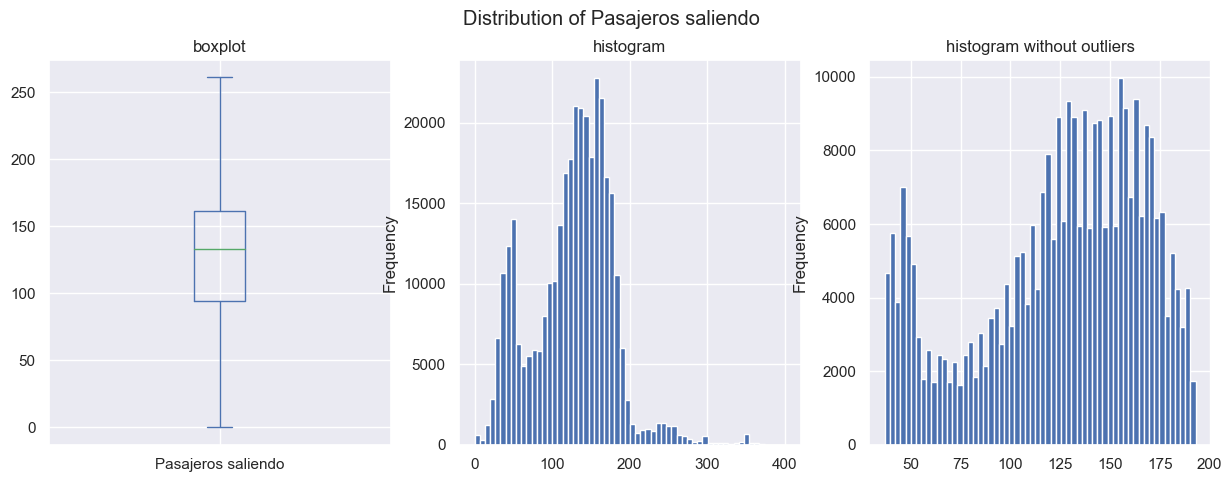

In [125]:
univariate_utils.plot_column_distribution(
        df_clean_flights,
        "Pasajeros saliendo",
        (15,5),
        60
    )

In [126]:
clip_data_by_iqr(df_clean_flights, "Pasajeros saliendo", "top", 1.5)

#### Estandarizacion de destino (Dimension de conformidad a nivel de atributo)
Se miran destinos que sean la misma ciudad (duplicados aproximados) y se reemplazan por la notacion mas comun.

In [127]:
sorted(
    df_clean_flights["Destino"].unique()
)

['abu dabi',
 'aguachica',
 'aguadilla',
 'alejandria',
 'amsterdam',
 'antofagasta',
 'apartado',
 'arauca',
 'armenia',
 'aruba',
 'asuncion',
 'atlanta',
 'bahamas',
 'balboa',
 'barcelona',
 'barrancabermeja',
 'barranquilla',
 'belo horizonte brasil',
 'boston',
 'bridgetown barbados',
 'brownsville',
 'bucaramanga',
 'buenaventura',
 'buenos aires',
 'buenos aires 2',
 'cali',
 'cancun',
 'caracas',
 'cartagena',
 'casablanca',
 'ciud panama',
 'cochabamba',
 'corozal',
 'cucuta',
 'curacao willemstad',
 'dallas',
 'dubai',
 'el yopal',
 'estambul',
 'florencia',
 'fort lauderdale',
 'frankfurt',
 'guadalajara',
 'guatemala',
 'guayaquil',
 'habana',
 'harlingen',
 'houston',
 'ibague',
 'ipiales',
 'la macarena',
 'la paz',
 'la romana rep dominicana',
 'leticia',
 'lima',
 'lisboa',
 'londres',
 'los angeles',
 'madrid',
 'manaos',
 'manizales',
 'maturin',
 'medellin',
 'mendoza argentina',
 'merida mexico',
 'mexico',
 'miami',
 'mitu',
 'monteria',
 'monterrey',
 'montevideo

In [128]:
fix_destino = {
    "buenos aires 2": "buenos aires",
    "phoenix eeuu": "phoenix arizona",
    "phoenix mesa arizona": "phoenix arizona",
}

In [129]:
standardize_categories(df_clean_flights, "Destino", fix_destino)

#### Estandarizacion de Muelle (Dimension de conformidad a nivel de atributo)
En los muelles se tienen muelles nacionales adicionales a los de las ventas, asi que se genera un formato similar al de las ventas para poder cruzar datos. 

In [130]:
sorted(
    df_clean_flights["Muelle"].unique()
)

['a internacional oriente',
 'b internacional occidente',
 'c nacional norte',
 'd nacional sur',
 'tpa']

In [131]:
fix_muelle = {
    "a internacional oriente": "muelle internacional oriente",
    "b internacional occidente": "muelle internacional occidente",
    "c nacional norte": "muelle nacional norte",
    "d nacional sur": "muelle nacional sur"
}

In [132]:
standardize_categories(df_clean_flights, "Muelle", fix_muelle)

In [133]:
sorted(
    df_clean_flights["Muelle"].unique()
)

['muelle internacional occidente',
 'muelle internacional oriente',
 'muelle nacional norte',
 'muelle nacional sur',
 'tpa']

### Agrupacion de vuelos en formato horario

Se toman las columnas categoricas relevantes y las de fecha y hora para generar informacion de numero de pasajeros agrupada por estos valores. Pero primero se eliminan duplicados por estas columnas.

In [134]:
df_clean_flights.drop_duplicates(
    subset=[
        "IATA CODE",
        "Destino",
        "Tipo de vuelo",
        "Sala",
        "Muelle",
        "AEROLÍNEA",
        "Tipo aerolínea",
        "STD_date",
        "Hora entera"
    ],
    inplace=True
)

In [135]:
df_hourly_flights = df_clean_flights.groupby([
    "IATA CODE",
    "Destino",
    "Tipo de vuelo",
    "Sala",
    "Muelle",
    "AEROLÍNEA",
    "Tipo aerolínea",
    "STD_date",
    "Hora entera"
]).agg({
    "FECHA DIA": "min",
    "Pasajeros saliendo": "sum",
    "Semana": "min",
    "Mes": "min",
    "Día": "min",
    "Año": "min",
    "STD": "min"
}).reset_index(drop=False)

In [136]:
df_hourly_flights = df_hourly_flights[RELEVANT_FLIGHT_COLUMNS + ["STD_date"]].copy(deep=True)

#### Revision de valores anomalos en "Pasajeros saliendo" generados por la agrupacion horaria

Por la dimension de conformidad se hace clipping de estos valores extremos a 1.5 * IQR.

In [137]:
univariate_utils.make_not_graphic_analysis(df_hourly_flights)

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343906 entries, 0 to 343905
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   IATA CODE           343906 non-null  object 
 1   Destino             343906 non-null  object 
 2   Tipo de vuelo       343906 non-null  object 
 3   Sala                343906 non-null  object 
 4   Muelle              343906 non-null  object 
 5   FECHA DIA           343906 non-null  object 
 6   AEROLÍNEA           343906 non-null  object 
 7   Tipo aerolínea      343906 non-null  object 
 8   STD                 343906 non-null  object 
 9   Pasajeros saliendo  343906 non-null  float64
 10  Hora entera         343906 non-null  int32  
 11  Semana              343906 non-null  int32  
 12  Mes                 343906 non-null  int32  
 13  Día                 343906 non-null  int32  
 14  Año                 343906 non-null  int32  
 15  STD_date 

IATA CODE             0.0
Destino               0.0
Tipo de vuelo         0.0
Sala                  0.0
Muelle                0.0
FECHA DIA             0.0
AEROLÍNEA             0.0
Tipo aerolínea        0.0
STD                   0.0
Pasajeros saliendo    0.0
Hora entera           0.0
Semana                0.0
Mes                   0.0
Día                   0.0
Año                   0.0
STD_date              0.0
dtype: float64

----- Object column statistics -----


,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,FECHA DIA,AEROLÍNEA,Tipo aerolínea,STD,STD_date
count,343906,343906,343906,343906,343906,343906,343906,343906,343906,343906
unique,126,120,2,75,5,7,52,5,244670,1099
top,MDE,medellin,domestico,d3,muelle nacional sur,viernes,avianca s a,legacy,2021-07-20 13:30:00,2023-01-02
freq,36910,42295,254054,10242,158393,50803,166992,256256,12,424


----- Number column statistics -----


,Pasajeros saliendo,Hora entera,Semana,Mes,Día,Año
count,343906.000000,343906.000000,343906.000000,343906.000000,343906.000000,343906.000000
mean,125.989567,12.569659,26.081231,6.413238,15.710057,2021.905620
std,51.193057,5.513535,14.917181,3.411315,8.818464,0.855774
min,0.000000,0.000000,1.000000,1.000000,1.000000,2020.000000
5%,37.250000,5.000000,3.000000,1.000000,2.000000,2021.000000
25%,94.000000,8.000000,13.000000,4.000000,8.000000,2021.000000
50%,133.000000,13.000000,26.000000,6.000000,16.000000,2022.000000
75%,161.000000,17.000000,38.000000,9.000000,23.000000,2023.000000
95%,193.000000,22.000000,50.000000,12.000000,29.000000,2023.000000
max,261.500000,23.000000,53.000000,12.000000,31.000000,2023.000000


----- First five rows -----


,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,FECHA DIA,AEROLÍNEA,Tipo aerolínea,STD,Pasajeros saliendo,Hora entera,Semana,Mes,Día,Año,STD_date
0,ADZ,san andres,domestico,c1,muelle nacional norte,martes,avianca s a,legacy,2021-07-20 13:44:00,103.0,13,29,7,20,2021,2021-07-20
1,ADZ,san andres,domestico,c1,muelle nacional norte,domingo,latam airlines,legacy,2020-11-22 13:22:00,169.0,13,47,11,22,2020,2020-11-22
2,ADZ,san andres,domestico,c1,muelle nacional norte,domingo,latam airlines,legacy,2021-05-30 09:21:00,133.0,9,21,5,30,2021,2021-05-30
3,ADZ,san andres,domestico,c1,muelle nacional norte,domingo,latam airlines,legacy,2021-07-04 07:16:00,134.0,7,26,7,4,2021,2021-07-04
4,ADZ,san andres,domestico,c1,muelle nacional norte,miercoles,latam airlines,legacy,2021-08-04 07:16:00,167.0,7,31,8,4,2021,2021-08-04


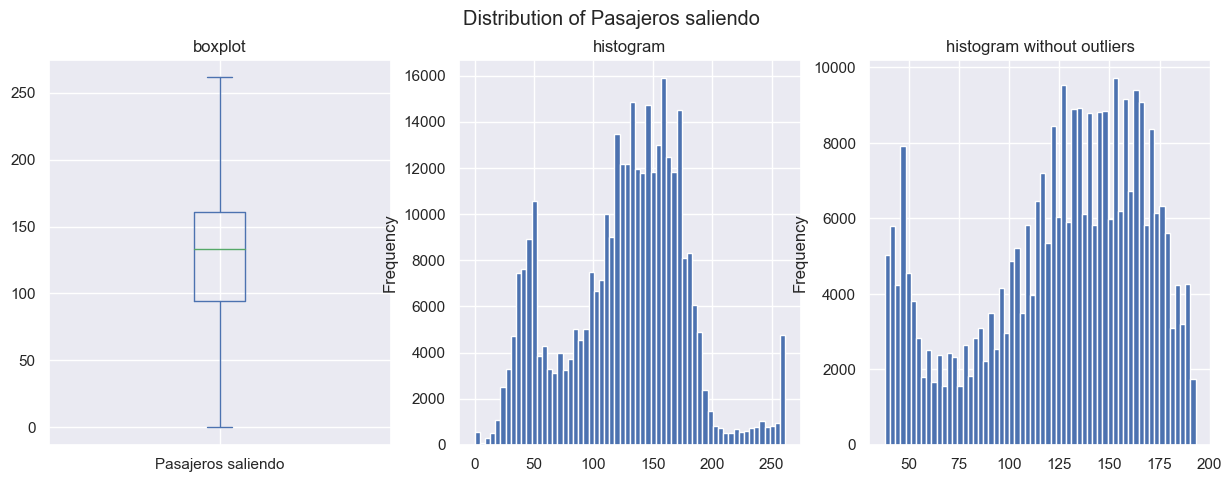

In [138]:
univariate_utils.plot_column_distribution(
        df_hourly_flights,
        "Pasajeros saliendo",
        (15,5),
        60
    )

In [139]:
clip_data_by_iqr(df_hourly_flights, "Pasajeros saliendo", "top", 1.5)

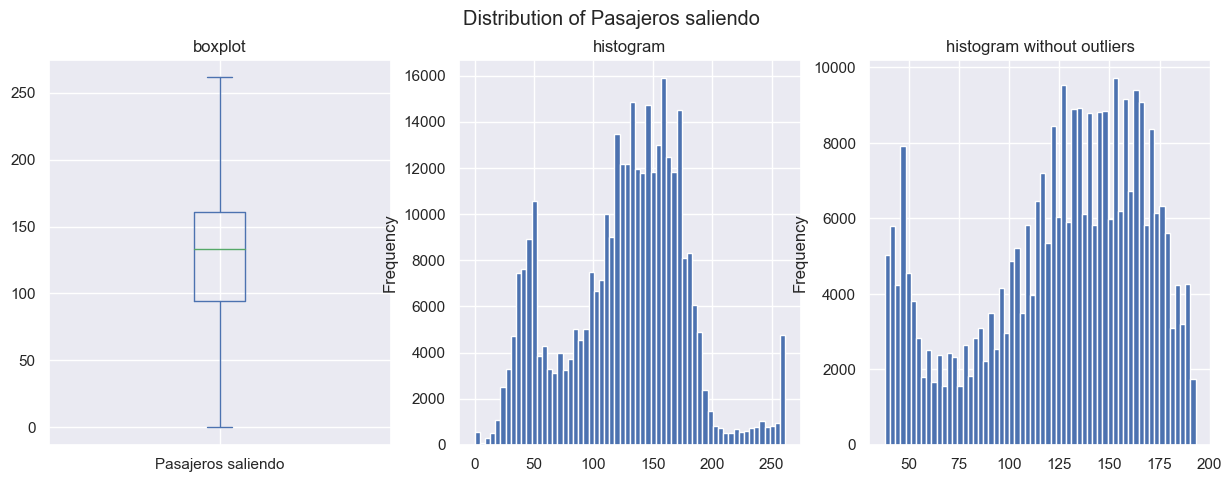

In [140]:
univariate_utils.plot_column_distribution(
        df_hourly_flights,
        "Pasajeros saliendo",
        (15,5),
        60
    )

### Conteo de pasajeros por Muelle, fecha y hora
Se agrupa por muelle, fecha y hora para calcular el trafico total del muelle a determinada fecha y hora.

In [141]:
df_hourly_flights["Pasajeros por Muelle y Hora"] = (
    df_hourly_flights.groupby(["Muelle", "STD", "Hora entera"])["Pasajeros saliendo"].transform("sum")
)

### Calculo de porcentaje de pasajeros de un muelle que salen a un vuelo en cierta fecha y hora

Se toma el numero de pasajeros en el muelle en ese momento y se calcula el porcentaje de pasajeros que van en un vuelo en ese mismo momento respecto de los del muelle.

In [142]:
df_hourly_flights["Porcentaje pasajeros vuelo"] = (
    df_hourly_flights["Pasajeros saliendo"] /
    df_hourly_flights["Pasajeros por Muelle y Hora"]
)

In [143]:
df_hourly_flights["Porcentaje pasajeros vuelo"] = \
    df_hourly_flights["Porcentaje pasajeros vuelo"].fillna(0.0)

In [144]:
df_hourly_flights["Porcentaje pasajeros vuelo"].describe()

count    343906.000000
mean          0.903131
std           0.215415
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Porcentaje pasajeros vuelo, dtype: float64

## **Generación del dataset clean_flights**

In [145]:
df_hourly_flights["STD"] = pd.to_datetime(df_hourly_flights["STD"])

df_hourly_flights.to_parquet(FLIGHTS_SAVE_FILE, index=False)